# Conformal Experiment: Gradual Overlap

- OvA
- Softmax

In [1]:
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import brentq

In [2]:
n_classes = 10
n_experts = 10

# Metric Calculation

In [3]:
def get_expert_prediction(experts, prediction_set_i, method="voting"):
    ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
    if method == "voting":
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "last": 
        exp_prediction = ensemble_expert_pred_i[-1] if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "random":
        idx = np.random.randint(len(ensemble_expert_pred_i)) if len(ensemble_expert_pred_i)!=0 else -1
        exp_prediction = ensemble_expert_pred_i[idx] if idx!=-1 else []
        
    return exp_prediction

## OvA

In [4]:
# === OvA ===
confs = []
exps = []
true = []
path = "ova_gradual_overlap/"

p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
for p in p_out:
    model_name = '_p_out_' + str(p)
    with open(path + 'confidence_multiple_experts' + model_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    # DANI Correction ===
    c = c.sigmoid()
    # DANI Correction ===
    confs.append(c)

In [5]:
n_val = int(0.8 * len(true[0]))
n_test = len(true[0]) - n_val
print("N val:{}".format(n_val))
print("N test:{}".format(n_test))

N val:7372
N test:1844


In [6]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
alpha = 0.1
n_classes = 10
n_experts = 10
n_classes_exp = n_classes + n_experts


In [7]:
# Method dict ===
method_list_ova = ["standard", "last", "random", "voting"]
method_dict_ova = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}

for method in method_list_ova:
    
    print("Method: {}\n".format(method))
    for i, p in enumerate(p_out):
        # =============
        # = Get Probs =
        # =============

        probs = confs[i]
        experts = exps[i]
        experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[:n_val, n_classes:]
        experts_val = [exp[:n_val] for exp in experts]
        y_true_val = y_true[:n_val]

        # Test ===
        probs_test = probs[n_val:, n_classes:]
        experts_test = [exp[n_val:] for exp in experts]
        y_true_test = y_true[n_val:]


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[:n_val].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]

        def false_negative_rate(prediction_set, gt_labels):
            return 1 - ((prediction_set*gt_labels).sum(axis=1)/gt_labels.sum(axis=1)).mean()

        #print(probs_experts.shape, np.array(experts_val).shape, y_true_val.shape)

        gt_labels = (np.array(experts_val) == np.array(y_true_val)).T

        #print(gt_labels.shape)

        n = gt_labels.shape[0]


        # Run the conformal risk control procedure
        def lamhat_threshold(lam): return false_negative_rate(probs_experts>=lam, gt_labels) - ((n+1)/n*alpha - 1/(n+1))
        lamhat = brentq(lamhat_threshold, 0, 1)
        prediction_sets = probs_experts >= 1-lamhat
        #print(prediction_sets.shape, torch.sum(prediction_sets, dim=1))
        print(f"The empirical FNR is: {false_negative_rate(prediction_sets, gt_labels)} and the threshold value is: {lamhat}")
        #print("Average Prediction Set Size is: {}".format(np.mean(torch.sum(prediction_sets, dim=1).numpy())))

        # # Model expert probs ===
        # # Sort J model outputs for experts
        # sort, pi = probs_experts.sort(dim=1, descending=True)

        # # Correctness experts ===
        # # Check if experts are correct 
        # correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # # idx for correct experts: [[0,1,2], [1,2], [], ...]
        # correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # # obtain the last expert to be retrieved. If empty, then add all values.
        # # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        # pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        # pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # # obtain real expert index back, e.g. [2,1,-1,...]
        # pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        # scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        # n_quantile = r.sum()
        # qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        # print("Q_hat {}: {}".format(p, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0
        prediction_set_size = 0
        prediction_set_len = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[n_val:]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    #sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    #pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = probs_test_exp[i] >= 1- lamhat #(pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets
                    prediction_set_len = sum(prediction_set_i)    

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])
                prediction_set_size += prediction_set_len

            real_total += 1

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total,
                    "prediction_set_size": prediction_set_size / (exp_total + 0.00002)}
        print(to_print, flush=True)

        # Save to method dict === 
        method_dict_ova[method].append(to_print)



Method: standard

The empirical FNR is: 0.9699094361671049 and the threshold value is: 0.16874410957062796
{'coverage': 84.97830802603036, 'system_accuracy': 82.48373101952278, 'expert_accuracy': 23.104676458717357, 'classifier_accuracy': 92.98021104146707, 'alone_classifier': 87.79826464208243, 'prediction_set_size': 0.0}
The empirical FNR is: 0.9475151238635979 and the threshold value is: 0.26362420618528426
{'coverage': 80.42299349240781, 'system_accuracy': 82.32104121475054, 'expert_accuracy': 34.072003284208705, 'classifier_accuracy': 94.0660759227191, 'alone_classifier': 86.8763557483731, 'prediction_set_size': 0.0}
The empirical FNR is: 0.8152220187220187 and the threshold value is: 0.44342832267207166
{'coverage': 73.86117136659436, 'system_accuracy': 84.97830802603036, 'expert_accuracy': 53.52694874400467, 'classifier_accuracy': 96.10865667337323, 'alone_classifier': 86.17136659436008, 'prediction_set_size': 0.0}
The empirical FNR is: 0.0 and the threshold value is: 0.60395714

## Softmax

In [8]:
# === Softmax ===
n_classes = 10
probs_softmax = []
confs = []
exps = []
true = []

path = "softmax_gradual_overlap/"
n_experts = 10
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
for p in p_out:
    model_name = '_p_out_' + str(p)
    with open(path + 'confidence_multiple_experts' + model_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    print(c.shape)
    # DANI Correction ===
    c = c.softmax(dim=1)
    probs_softmax.append(c)
    # DANI Correction ===

    temp = 0
    for i in range(n_experts):
        temp += c[:, (n_classes + n_experts) - (i + 1)]
    prob = c / (1.0 - temp).unsqueeze(-1)
    confs.append(prob)


torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])
torch.Size([9216, 20])


In [9]:
# Method dict ===
method_list_softmax = ["standard", "last", "random", "voting"]
method_dict_softmax = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}

for method in method_list_softmax:
    
    print("Method: {}\n".format(method))
    for i, p in enumerate(p_out):
        # =============
        # = Get Probs =
        # =============

        probs = probs_softmax[i]
        experts = exps[i]
        experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[:n_val, n_classes:]
        experts_val = [exp[:n_val] for exp in experts]
        y_true_val = y_true[:n_val]

        # Test ===
        probs_test = probs[n_val:, n_classes:]
        experts_test = [exp[n_val:] for exp in experts]
        y_true_test = y_true[n_val:]


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[:n_val].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]


        def false_negative_rate(prediction_set, gt_labels):
            return 1 - ((prediction_set*gt_labels).sum(axis=1)/gt_labels.sum(axis=1)).mean()

        #print(probs_experts.shape, np.array(experts_val).shape, y_true_val.shape)

        gt_labels = (np.array(experts_val) == np.array(y_true_val)).T

        #print(gt_labels.shape)

        n = gt_labels.shape[0]


        # Run the conformal risk control procedure
        def lamhat_threshold(lam): return false_negative_rate(probs_experts>=(lam), gt_labels) - ((n+1)/n*alpha - 1/(n+1))
        lamhat = brentq(lamhat_threshold, 0, 0.1)
        prediction_sets = probs_experts >= 0.1 - lamhat
        print(f"The empirical FNR is: {false_negative_rate(prediction_sets, gt_labels)} and the threshold value is: {lamhat}")

        # Model expert probs ===
        # Sort J model outputs for experts
        #sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        #correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        #correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        #pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        #pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        #pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        #scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        #n_quantile = r.sum()
        #qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        #print("Q_hat {}: {}".format(p, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0
        prediction_set_size = 0
        prediction_set_len = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[n_val:]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    #sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    #pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = probs_test_exp[i] >= 0.1 - lamhat #(pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets
                    prediction_set_len = sum(prediction_set_i)        

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])
                prediction_set_size += prediction_set_len

            real_total += 1

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total,
                    "prediction_set_size": prediction_set_size / (exp_total + 0.00002)}
        print(to_print, flush=True)

        # Save to method dict === 
        method_dict_softmax[method].append(to_print)



Method: standard

The empirical FNR is: 0.40611946050096337 and the threshold value is: 0.04714297689555654
{'coverage': 43.275488069414315, 'system_accuracy': 51.13882863340564, 'expert_accuracy': 22.370932625060686, 'classifier_accuracy': 88.84710666076359, 'alone_classifier': 86.8763557483731, 'prediction_set_size': 0.0}
The empirical FNR is: 0.0007746806039489185 and the threshold value is: 0.056191558019239245
{'coverage': 40.23861171366595, 'system_accuracy': 54.66377440347072, 'expert_accuracy': 29.85480401909183, 'classifier_accuracy': 91.509421629458, 'alone_classifier': 84.86984815618221, 'prediction_set_size': 0.0}
The empirical FNR is: 0.0 and the threshold value is: 0.06854746863295147
{'coverage': 28.524945770065077, 'system_accuracy': 60.140997830802604, 'expert_accuracy': 48.558414482789914, 'classifier_accuracy': 89.16348114762717, 'alone_classifier': 85.73752711496746, 'prediction_set_size': 0.0}
The empirical FNR is: 0.0 and the threshold value is: 0.0771316178151010

## Plot results

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc

# # === Latex Options === #
rc('font', family='serif')
rc('text', usetex=True)

# === Matplotlib Options === #
cm = plt.cm.get_cmap('tab10')
plot_args = {"marker": "o",
             "markeredgecolor": "k",
             "markersize": 10,
             "linewidth": 8
             }
sns.set_context("talk", font_scale=1.3)
fig_size = (7,7)


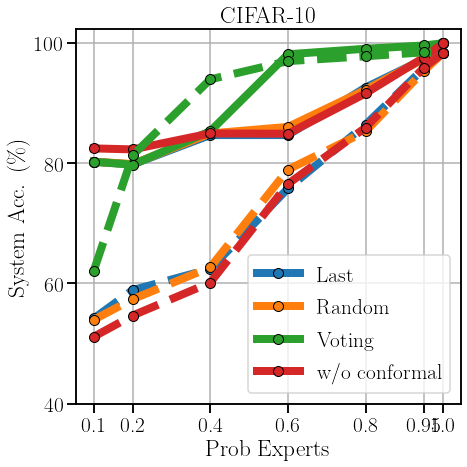

In [11]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]


# OvA ===
sys_acc_standard_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["standard"]])
sys_acc_last_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["last"]])
sys_acc_random_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["random"]])
sys_acc_voting_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["voting"]])

# Softmax ===
sys_acc_standard_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["standard"]])
sys_acc_last_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["last"]])
sys_acc_random_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["random"]])
sys_acc_voting_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["voting"]])


f, ax = plt.subplots(1, 1, figsize=fig_size)
# OvA ===
ax.plot(p_out, sys_acc_last_ova, "-", label=r"Last", color=cm(0), **plot_args)
ax.plot(p_out, sys_acc_random_ova, "-", label=r"Random", color=cm(1), **plot_args)
ax.plot(p_out, sys_acc_voting_ova, "-", label=r"Voting", color=cm(2), **plot_args)
ax.plot(p_out, sys_acc_standard_ova, "-", label=r"w/o conformal", color=cm(3), **plot_args)

# Softmax ===
ax.plot(p_out, sys_acc_last_softmax, "--", color=cm(0), **plot_args)
ax.plot(p_out, sys_acc_random_softmax, "--", color=cm(1), **plot_args)
ax.plot(p_out, sys_acc_voting_softmax, "--", color=cm(2), **plot_args)
ax.plot(p_out, sys_acc_standard_softmax, "--", color=cm(3), **plot_args)

plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'System Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()

plt.savefig("system_acc_gradual_overlap_risk_control.pdf")

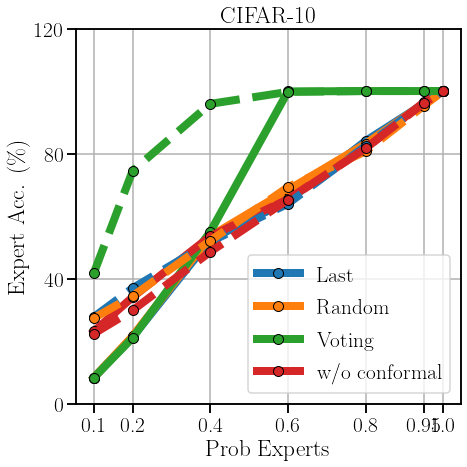

In [12]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]


# OvA ===
exp_acc_standard_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["standard"]])
exp_acc_last_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["last"]])
exp_acc_random_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["random"]])
exp_acc_voting_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["voting"]])

# Softmax ===
exp_acc_standard_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["standard"]])
exp_acc_last_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["last"]])
exp_acc_random_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["random"]])
exp_acc_voting_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["voting"]])


f, ax = plt.subplots(1, 1, figsize=fig_size)
# OvA ===
ax.plot(p_out, exp_acc_last_ova, "-", label=r"Last", color=cm(0), **plot_args)
ax.plot(p_out, exp_acc_random_ova, "-", label=r"Random", color=cm(1), **plot_args)
ax.plot(p_out, exp_acc_voting_ova, "-", label=r"Voting", color=cm(2), **plot_args)
ax.plot(p_out, exp_acc_standard_ova, "-", label=r"w/o conformal", color=cm(3), **plot_args)

# Softmax ===
ax.plot(p_out, exp_acc_last_softmax, "--", color=cm(0), **plot_args)
ax.plot(p_out, exp_acc_random_softmax, "--", color=cm(1), **plot_args)
ax.plot(p_out, exp_acc_voting_softmax, "--", color=cm(2), **plot_args)
ax.plot(p_out, exp_acc_standard_softmax, "--", color=cm(3), **plot_args)

plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Expert Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()

plt.savefig("expert_acc_gradual_overlap_risk_control.pdf")


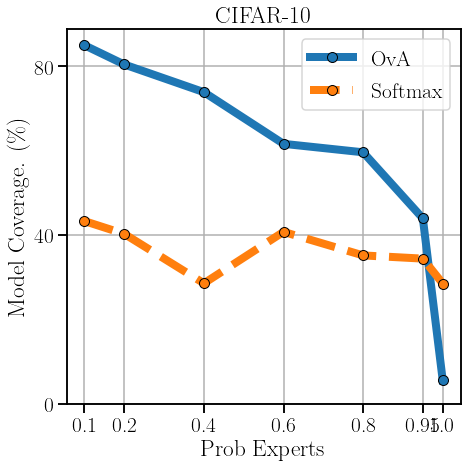

In [13]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
coverage_ova = np.array([method_d["coverage"] for method_d in method_dict_ova["last"]])
coverage_softmax = np.array([method_d["coverage"] for method_d in method_dict_softmax["last"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(p_out, coverage_ova, "-", label=r"OvA", **plot_args)
ax.plot(p_out, coverage_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Model Coverage. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


plt.savefig("coverage_gradual_overlap_risk_control.pdf")


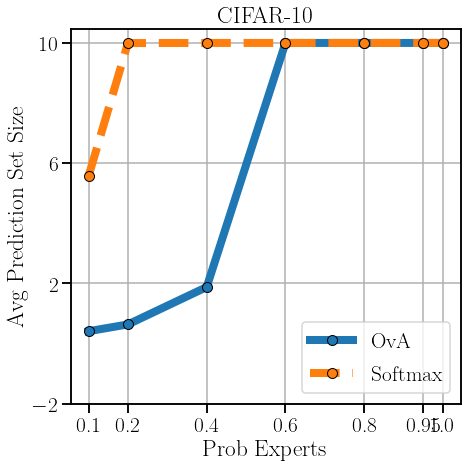

In [14]:
p_out = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
prediction_set_size_ova = np.array([method_d["prediction_set_size"] for method_d in method_dict_ova["random"]])
prediction_set_size_softmax = np.array([method_d["prediction_set_size"] for method_d in method_dict_softmax["random"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(p_out, prediction_set_size_ova, "-", label=r"OvA", **plot_args)
ax.plot(p_out, prediction_set_size_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(p_out, p_out)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Avg Prediction Set Size')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


plt.savefig("prediction_set_size_gradual_overlap_risk_control.pdf")